In [1]:
!nvidia-smi

Sat Mar 11 10:53:01 KST 2023

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:14:00.0 Off |                    0 |
| N/A   32C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32

In [2]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.25.1
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "Pancreas-CT"

In [4]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "data", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "TCIA_pancreas_labels-02-05-2017", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
print(len(data_dicts))

82


In [5]:
def nii_loader(filename):
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    nimg = nib.load( filename )
    return nimg.get_fdata() , nimg.affine, nimg.header

In [6]:
new_data_dir = "Pancreas-CT/230311"
target_layers = list()

with open(os.path.join(new_data_dir, "230311 target_layer.txt"), 'r') as f:
    for idx in range(len(data_dicts)):
        target_layers.append(int(f.readline().split()[1]))
        
print(target_layers)

[126, 89, 90, 96, 96, 96, 103, 104, 102, 90, 96, 107, 75, 132, 108, 181, 131, 101, 100, 102, 105, 185, 124, 168, 89, 140, 93, 106, 82, 182, 131, 127, 144, 73, 98, 69, 66, 115, 96, 117, 109, 142, 104, 273, 96, 80, 97, 88, 89, 141, 95, 112, 155, 80, 65, 111, 100, 128, 102, 124, 96, 134, 137, 113, 94, 85, 112, 93, 99, 100, 89, 78, 149, 99, 115, 96, 96, 136, 110, 89, 106, 118]


In [7]:
def nii_saver(dataset, idx, target_layers):
    import nibabel as nib
    image = dataset[idx]['image']
    label = dataset[idx]['label']

    image_data, image_affine, image_header = nii_loader(image)
    label_data, label_affine, label_header = nii_loader(label)
    
    target_image = image_data[:,:,target_layers[idx]]
    target_label = label_data[:,:,target_layers[idx]]
    
    new_image = nib.Nifti1Image(target_image, None)
    new_label = nib.Nifti1Image(target_label, None)
    
    new_image_dir = os.path.join(new_data_dir, "data", os.path.basename(image))
    new_label_dir = os.path.join(new_data_dir, "TCIA_pancreas_labels-02-05-2017", os.path.basename(label))
    
    nib.save(new_image, new_image_dir)
    print(f'Saved to {new_image_dir}')
    nib.save(new_label, new_label_dir)
    print(f'Saved to {new_label_dir}')

In [8]:
for idx in range(len(data_dicts)):
    nii_saver(data_dicts, idx, target_layers)

Saved to Pancreas-CT/230311/data/PANCREAS_0001.nii.gz
Saved to Pancreas-CT/230311/TCIA_pancreas_labels-02-05-2017/label0001.nii.gz
Saved to Pancreas-CT/230311/data/PANCREAS_0002.nii.gz
Saved to Pancreas-CT/230311/TCIA_pancreas_labels-02-05-2017/label0002.nii.gz
Saved to Pancreas-CT/230311/data/PANCREAS_0003.nii.gz
Saved to Pancreas-CT/230311/TCIA_pancreas_labels-02-05-2017/label0003.nii.gz
Saved to Pancreas-CT/230311/data/PANCREAS_0004.nii.gz
Saved to Pancreas-CT/230311/TCIA_pancreas_labels-02-05-2017/label0004.nii.gz
Saved to Pancreas-CT/230311/data/PANCREAS_0005.nii.gz
Saved to Pancreas-CT/230311/TCIA_pancreas_labels-02-05-2017/label0005.nii.gz
Saved to Pancreas-CT/230311/data/PANCREAS_0006.nii.gz
Saved to Pancreas-CT/230311/TCIA_pancreas_labels-02-05-2017/label0006.nii.gz
Saved to Pancreas-CT/230311/data/PANCREAS_0007.nii.gz
Saved to Pancreas-CT/230311/TCIA_pancreas_labels-02-05-2017/label0007.nii.gz
Saved to Pancreas-CT/230311/data/PANCREAS_0008.nii.gz
Saved to Pancreas-CT/230311/T

In [9]:
new_train_images = sorted(
    glob.glob(os.path.join(new_data_dir, "data", "*.nii.gz")))
new_train_labels = sorted(
    glob.glob(os.path.join(new_data_dir, "TCIA_pancreas_labels-02-05-2017", "*.nii.gz")))
new_data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(new_train_images, new_train_labels)
]
print(len(data_dicts))

82


In [10]:
def visualize(dataset, idx=0):
    import matplotlib.pyplot as plt    

    image = dataset[idx]['image']
    label = dataset[idx]['label']

    image_data, image_affine, image_header = nii_loader(image)
    label_data, label_affine, label_header = nii_loader(label)

    print(image_data.shape, label_data.shape )
    target_image = image_data[:,:]
    target_label = label_data[:,:]

    fig, (ax1, ax2) = plt.subplots(1, 2 ,  figsize=(12,8))

    ax1.imshow(image_data, cmap='gray' )
    ax1.set_title('image')
    ax2.imshow(label_data)
    ax2.set_title('GT segmentation')
    plt.show()

(512, 512) (512, 512)


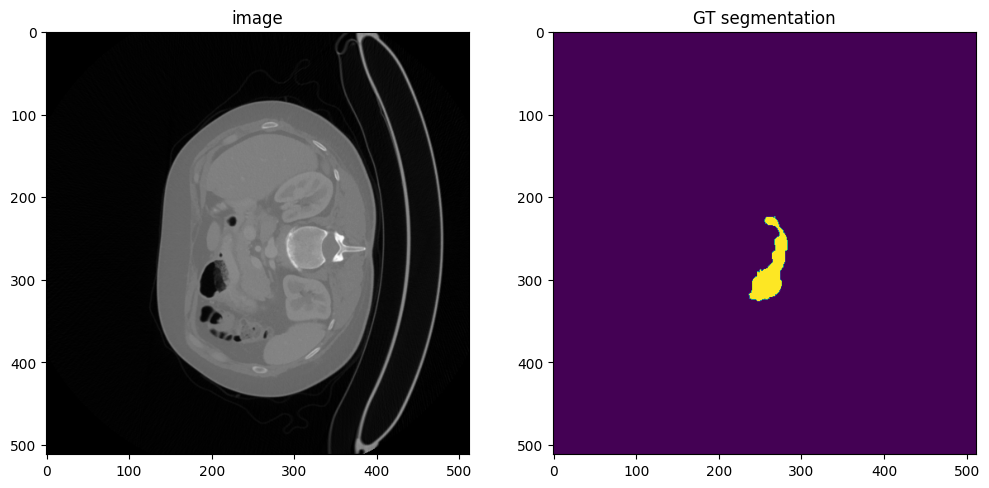

In [11]:
visualize(new_data_dicts, idx=0)